In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_palette("GnBu_d")
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


%matplotlib inline

In [2]:
brm_hourly_driven = pd.read_csv("../generated/brm_hourly_driven.csv")
frb_hourly_driven = pd.read_csv("../generated/frb_hourly_driven.csv")

brm_hourly_weather = pd.read_csv("../generated/brm_hourly_weather.csv")
frb_hourly_weather = pd.read_csv("../generated/frb_hourly_weather.csv")

## Prediction

In [3]:
def merge_duration_and_weather(duration, weather):
    return duration.merge(how="left", left_on=["day", "hour"], right_on=["day","hour"], right=weather)

def timedelta_to_hours(timedelta_array):
    return timedelta_array.map(lambda x: x / pd.Timedelta("1 hour"))

def add_weekday(frame):
    frame["day"] = pd.to_datetime(frame["day"])
    frame["weekday"] = frame["day"].map(lambda x: x.weekday())
    return frame
    
def split_weekday(frame):
    frame = add_weekday(frame)
    weekdays = [None]*7
    for i in range(0,6):
        weekdays[i] = frame[frame["weekday"]==i]
    return weekdays

def regression(frame,frame_model):
    y = frame["trip_duration"]
    X = frame[["temperature","precipitation"]]
    frame_model.fit(X, y)
    predict = frame_model.predict(X)
    return predict

def plot_regression(X,y, predict):
    plt.figure(figsize = (8,6))
    plt.scatter(X, y, marker="x")
    plt.xlabel("temperature in °C")
    plt.ylabel("trip duration in h")
    plt.plot(X, predict, c='C2')
    plt.legend(['Squared loss fit','Observed hours'])


def split(X, y, train_size, validate_size):
    if (train_size+validate_size) <= 1:
        x_train, x_tmp, y_train, y_tmp = train_test_split(X, y, test_size=(1-train_size))
        x_validate, x_test, y_validate, y_test = train_test_split(x_tmp, y_tmp, test_size=(1-validate_size/(1-train_size)))
        return x_train, x_validate, x_test, y_train, y_validate, y_test
    

In [4]:
frb_hourly = merge_duration_and_weather(frb_hourly_driven, frb_hourly_weather)
frb_hourly["trip_duration"] = timedelta_to_hours(frb_hourly["trip_duration"])

brm_hourly = merge_duration_and_weather(brm_hourly_driven, brm_hourly_weather)
brm_hourly["trip_duration"] = timedelta_to_hours(brm_hourly["trip_duration"])

frb_weekdays = split_weekday(frb_hourly)
brm_weekdays = split_weekday(brm_hourly)

In [5]:
x = frb_weekdays[0]["trip_duration"]
f1 = frb_weekdays[0]["temperature"]
f2 = frb_weekdays[0]["precipitation"]
f3 = frb_weekdays[0]["hour"]

Example plot for mondays

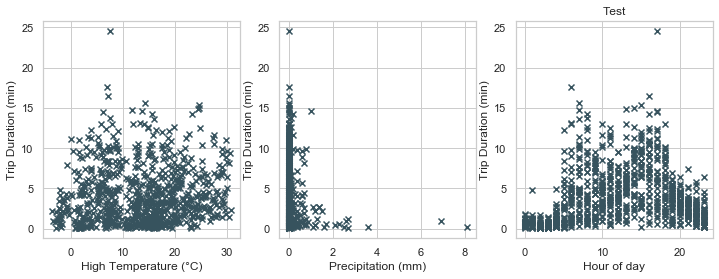

In [14]:
fig = plt.figure(figsize = (12,4))
ax = fig.add_subplot(1,3,1)
ax.scatter(f1,x, marker='x')
ax.set_xlabel("High Temperature (°C)")
ax.set_ylabel("Trip Duration (min)")
bx =  fig.add_subplot(1,3,2)
bx.scatter(f2,x, marker='x')
bx.set_xlabel("Precipitation (mm)")
bx.set_ylabel("Trip Duration (min)")
cx =  fig.add_subplot(1,3,3)
cx.scatter(f3,x, marker='x')
cx.set_xlabel("Hour of day")
cx.set_ylabel("Trip Duration (min)")
plt.show()

In [20]:
#Split

X = frb_weekdays[0][["precipitation", "temperature", "hour"]]
y = frb_weekdays[0]["trip_duration"]

x_train, x_validate, x_test, y_train, y_validate, y_test = split(X, y, train_size=0.6, validate_size=0.2)

###  Linear regression

[-0.90701334  0.01960404  0.0951199 ] 2.7913958821942657
MSE: 11.840835172654566


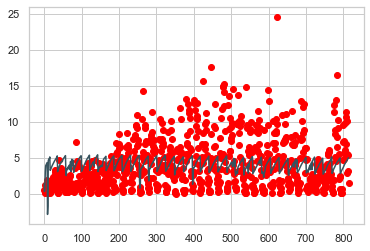

In [21]:
linear_model = LinearRegression()

linear_model.fit(X, y)
print(linear_model.coef_, linear_model.intercept_)

predict = linear_model.predict(X)
print("MSE:", mean_squared_error(y, predict))

plt.scatter(range(0,y.values.size), y, c="red")
plt.plot(range(0,predict.size), predict)


### Polynomial regression

MSE: 8.194654100587277


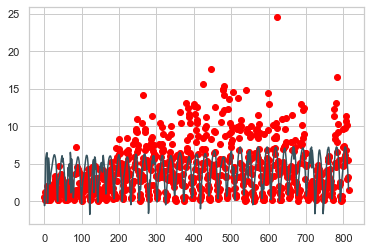

In [28]:
polynomial_model = LinearRegression()
poly_features = PolynomialFeatures(degree=3)
x_poly = poly_features.fit_transform(X)
x_poly_validate = poly_features.fit_transform(X)

polynomial_model.fit(x_poly, y)
predict = polynomial_model.predict(x_poly)
print("MSE:", mean_squared_error(y, predict))

plt.scatter(range(0,y.values.size), y, c="red")
plt.plot(range(0,predict.size), predict)


Split the data set into traing(60%), validation(20%), test(20%) setst to prevent leakage.

In [8]:
x_train, x_validate, x_test = np.split(brm_weekdays[0]['temperature'].sample(frac=1), [int(.6*len(brm_weekdays[0]['temperature'])), int(.8*len(brm_weekdays[0]['temperature']))])
y_train, y_validate, y_test = np.split(brm_weekdays[0]['trip_duration'].sample(frac=1), [int(.6*len(brm_weekdays[0]['trip_duration'])), int(.8*len(brm_weekdays[0]['trip_duration']))])

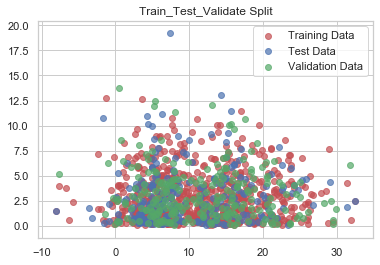

In [9]:
plt.scatter(x_train, y_train, label = "Training Data", color = "r", alpha =.7)
plt.scatter(x_test, y_test, label = "Test Data", color = "b", alpha =.7)
plt.scatter(x_validate, y_validate, label = "Validation Data", color = "g", alpha =.7)
plt.legend()
plt.title("Train_Test_Validate Split")
plt.show()

In [10]:
#Create linear model and train it 
lr = LinearRegression()
lr.fit(x_train.values.reshape(-1, 1), y_train.values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

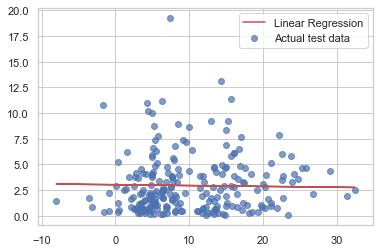

In [11]:
# Use model to predict on test data
prediction = lr.predict(x_test.values.reshape(-1, 1))

# Plot prediction line against actual test data 
plt.plot(x_test, prediction, label='Linear Regression', color = 'r')
plt.scatter(x_test, y_test, label='Actual test data', color = 'b', alpha=.7)
plt.legend()
plt.show()

The best score that we could achieve for a model is 1.0. 
~Soo our linear model is not that great...

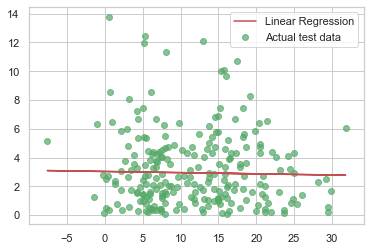

In [12]:
# Plot prediction line against actual test data 
prediction = lr.predict(x_validate.values.reshape(-1, 1))
plt.plot(x_validate, prediction, label='Linear Regression', color = 'r')
plt.scatter(x_validate, y_validate, label='Actual test data', color = 'g', alpha=.7)
plt.legend()
plt.show()

In [13]:
# Score the model 
lr.score(x_validate.values.reshape(-1, 1), y_validate.values)

-0.007570534040405974

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [15]:
y_true = y_validate
y_pred = lr.predict(x_validate.values.reshape((-1,1)))

In [16]:
print("Mean Squared Error:",mean_squared_error(y_pred, y_true))
print("Root Mean Squared Error:",mean_squared_error(y_pred, y_true)**0.5)
print("Coefficient of determination:",r2_score(y_pred, y_true))

Mean Squared Error: 6.886992996933021
Root Mean Squared Error: 2.6243080987058325
Coefficient of determination: -1939.3102275014262


### Polynomial  regression

In [17]:
from sklearn.preprocessing import PolynomialFeatures


In [18]:
def plot_regression_poly(X,Y,d):
    
    # initialize PolynomialFeatures
    poly_reg = PolynomialFeatures (degree = d)
    
    # Polynomial transformation
    x_poly = poly_reg.fit_transform(X.reshape(-1,1))
    lin_reg_Poly = LinearRegression()
    
    # Fitting linear regression to polynomial features
    lin_reg_Poly.fit(x_poly, Y)
    model_pred = lin_reg_Poly.predict(x_poly)
    
    # Plotting the regression line and the data (we have to transform the inputs as well!)
    x_fit = np.arange(X.min(),X.max() ,1)[:, np.newaxis]
    y_pred = lin_reg_Poly.predict(poly_reg.fit_transform(x_fit.reshape(-1,1)))
    
    plt.figure(figsize = (8,6))
    plt.scatter(X,Y,marker="o", c='C2')
    ylim = plt.ylim()
    plt.plot(x_fit,y_pred, c='C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (Min)")
    plt.xlim([X.min()-2,X.max()+2]) # leave some space before and after limits
    plt.ylim(ylim)
    print ('The R^2 for quadratic curve is: ',r2_score(Y, model_pred))
    print(lin_reg_Poly.coef_) 

The R^2 for quadratic curve is:  0.002345651472865473
[ 0.00000000e+00  2.28362884e-02 -9.21104126e-03  6.13558265e-04
 -1.16708020e-05]


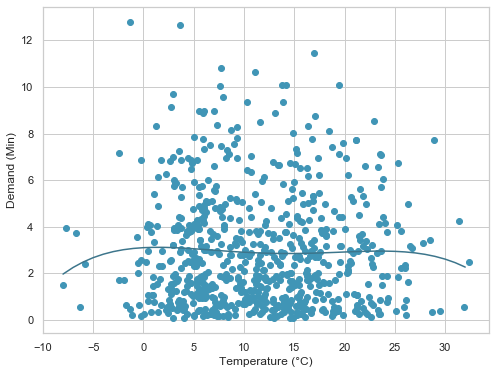

In [19]:
xp = x_train.values

yp = y_train 

plot_regression_poly(X = xp, Y = yp, d = 4)

The R^2 for quadratic curve is:  0.009985657266705417
[ 0.00000000e+00  1.18639626e-01 -3.20866155e-03 -1.02256306e-04
  3.33238066e-06]


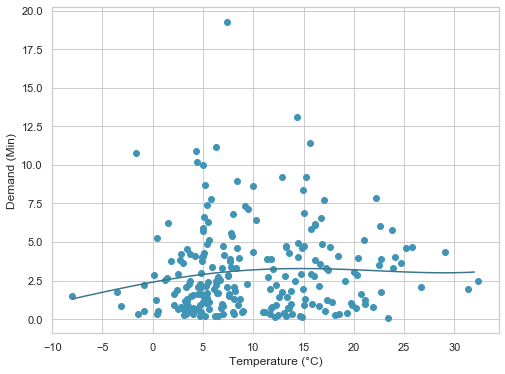

In [20]:
xp = x_test.values

yp = y_test 

plot_regression_poly(X = xp, Y = yp, d = 4)

The R^2 for quadratic curve is:  0.014606654066308233
[ 0.00000000e+00 -1.32505363e-01  2.19776178e-02 -1.16886509e-03
  1.78455799e-05]


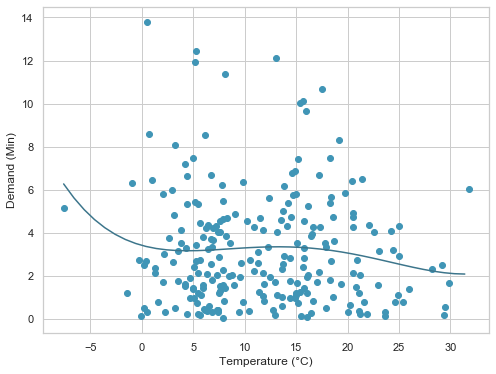

In [21]:
xp = x_validate.values

yp = y_validate 

plot_regression_poly(X = xp, Y = yp, d = 4)

In [22]:
plot_regression_poly

<function __main__.plot_regression_poly(X, Y, d)>

### Idea

Split dataset into train_test_validate sets not for every hour individually but rather hourly.